91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02123045', 'tabby', 0.08881315)]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


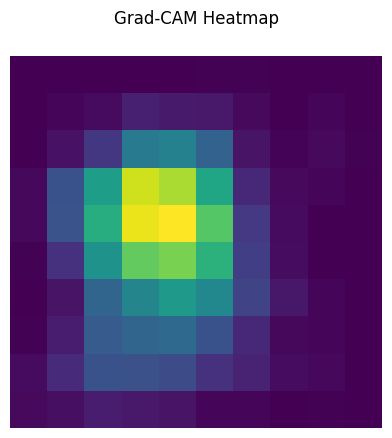

In [ ]:
# Grad-CAM Implementation with Xception

import os
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from IPython.display import Image, display
import matplotlib.pyplot as plt

# Keras backend
os.environ["KERAS_BACKEND"] = "tensorflow"

# Preprocess image
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Grad-CAM algorithm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Path to image
img_path = "/content/catdog.jpg"  # Replace with your image path
img_size = (299, 299)


img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Loading Xception model
model = Xception(weights="imagenet")
model.layers[-1].activation = None
model = Model(inputs=model.inputs, outputs=model.output)  # Rebuild model to apply changes

# Make predictions
preds = model.predict(img_array)
probs = tf.nn.softmax(preds).numpy()
print("Predicted:", keras.applications.xception.decode_predictions(probs, top=1)[0])

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, "block14_sepconv2_act")

# Display heatmap
plt.matshow(heatmap)
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()

In [ ]:
# Parkinson's Disease Detection from MRI Scans with Grad-CAM

# Step 1: Install & Import

!pip install -q kaggle

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import shutil

In [ ]:
# Step 2: Kaggle API Setup

# kaggle.json file (API token from your Kaggle account)
from google.colab import files
files.upload()  # Choose your kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Step 3: Download Dataset

!kaggle datasets download -d irfansheriff/parkinsons-brain-mri-dataset
!unzip -q parkinsons-brain-mri-dataset.zip -d parkinsons_mri

Dataset URL: https://www.kaggle.com/datasets/irfansheriff/parkinsons-brain-mri-dataset
License(s): unknown
 74% 19.0M/25.8M [00:00<00:00, 54.4MB/s]
100% 25.8M/25.8M [00:00<00:00, 66.7MB/s]


In [ ]:
# Step 4: Data Preprocessing

data_dir = "/content/parkinsons_mri/parkinsons_dataset"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 665 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


In [ ]:
# Step 5: Build the Model

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,123,881 (80.58 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Step 6: Train the Model

history = model.fit(train_gen, validation_data=val_gen, epochs=20)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 463ms/step - accuracy: 0.7701 - loss: 0.4614 - val_accuracy: 0.7952 - val_loss: 0.3151
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9150 - loss: 0.1911 - val_accuracy: 0.9398 - val_loss: 0.1376
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9871 - loss: 0.0825 - val_accuracy: 0.9518 - val_loss: 0.1198
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9972 - loss: 0.0403 - val_accuracy: 0.9157 - val_loss: 0.1546
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.0299 - val_accuracy: 0.8976 - val_loss: 0.1822
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9977 - loss: 0.0189 - val_accuracy: 0.9458 - val_loss: 0.1161
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 0.0125 - val_accuracy: 0.9458 - val_loss: 0.0991
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0

In [ ]:
# Step 7: Grad-CAM Function

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_269']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


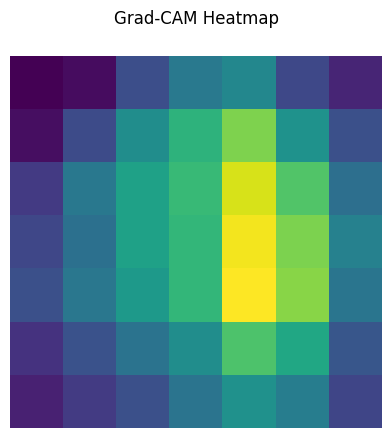

In [ ]:
# Step 8: Run Grad-CAM on Sample

from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return preprocess_input(array)

# testing with sample image from the dataset
sample_path = os.path.join(data_dir, "parkinson", os.listdir(os.path.join(data_dir, "parkinson"))[0])
img_array = load_and_preprocess_image(sample_path)

# Grad-CAM
heatmap = make_gradcam_heatmap(img_array, model, 'block14_sepconv2_act')

# Display heatmap
plt.matshow(heatmap)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalizing heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()

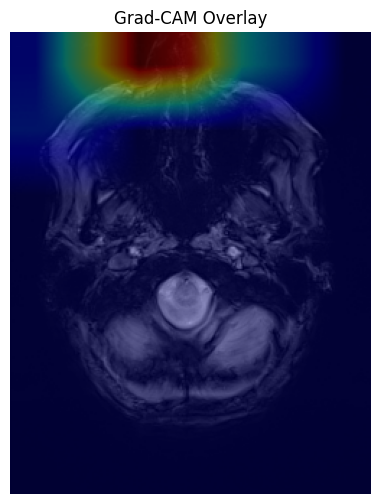

In [ ]:
# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/normal/Mag_Images_006.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display result
display_gradcam(img_path, heatmap)

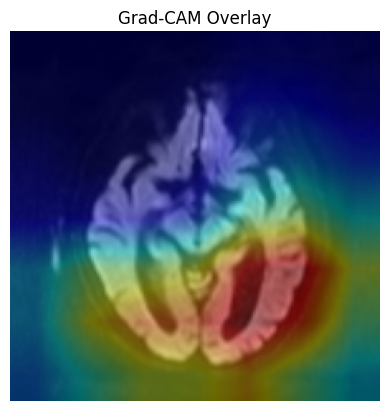

In [ ]:
# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/parkinson/Reg_-_sDW_SSh_SENSE_020.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display result
display_gradcam(img_path, heatmap)

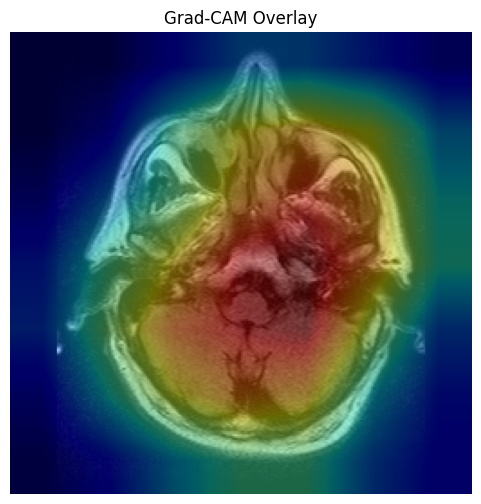

In [ ]:
# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/parkinson/T2W_FLAIR_004.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display result
display_gradcam(img_path, heatmap)

# FINAL WITH CLASS PREDICTION

In [ ]:
def display_gradcam(img_path, heatmap, title='Grad-CAM Overlay'):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_rgb, 0.4, 0)

    # Display
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


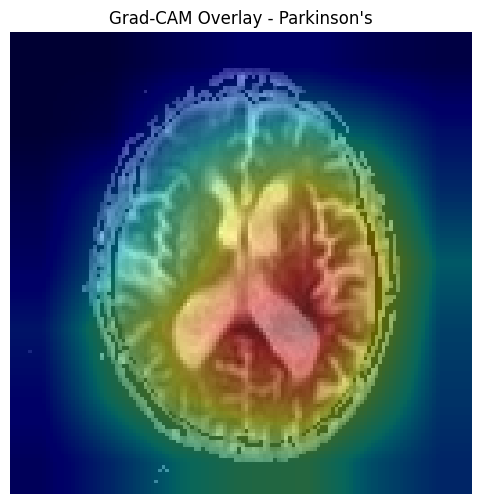

In [ ]:
# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/parkinson/dReg_-_sDW_SSh_SENSE_013.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Get prediction from model
prediction = model.predict(img_array)
predicted_label = "Parkinson's" if prediction[0][0] > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display result with label in title
display_gradcam(img_path, heatmap, title=f"Grad-CAM Overlay - {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


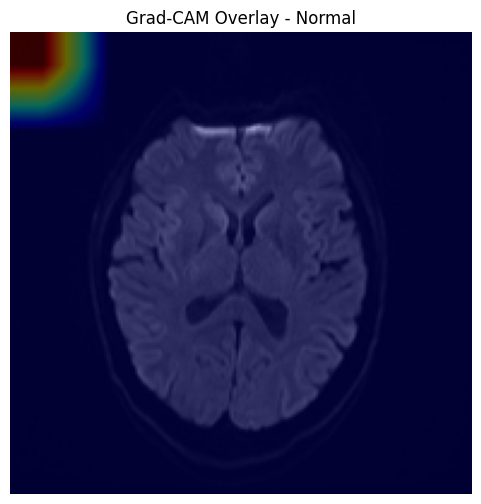

In [ ]:
# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/normal/ep2d_diff_3scan_trace_p2_TRACEW_DFC_048.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Get prediction from model
prediction = model.predict(img_array)
predicted_label = "Parkinson's" if prediction[0][0] > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display result with label in title
display_gradcam(img_path, heatmap, title=f"Grad-CAM Overlay - {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


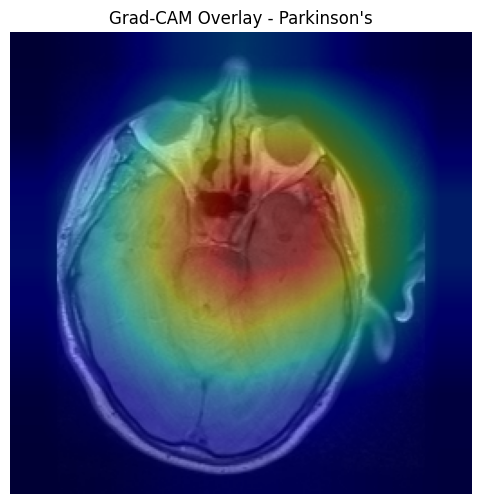

In [ ]:
# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/parkinson/DUAL_TSE_013.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Get prediction from model
prediction = model.predict(img_array)
predicted_label = "Parkinson's" if prediction[0][0] > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display result with label in title
display_gradcam(img_path, heatmap, title=f"Grad-CAM Overlay - {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


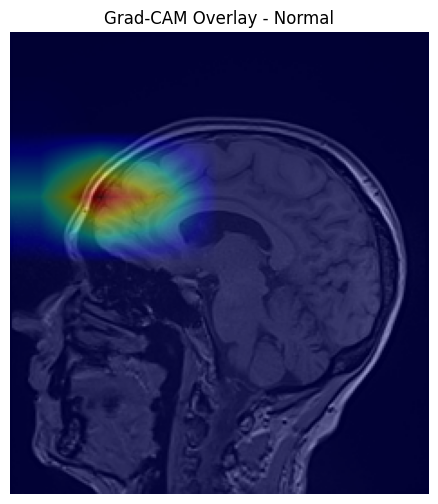

In [ ]:
# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/normal/t1_fl3d_sag_p4_iso_1.0_094.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Get prediction from model
prediction = model.predict(img_array)
predicted_label = "Parkinson's" if prediction[0][0] > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display result with label in title
display_gradcam(img_path, heatmap, title=f"Grad-CAM Overlay - {predicted_label}")

# CONFIDENCE LEVEL FOR PREDICTION OF PARKINSON

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


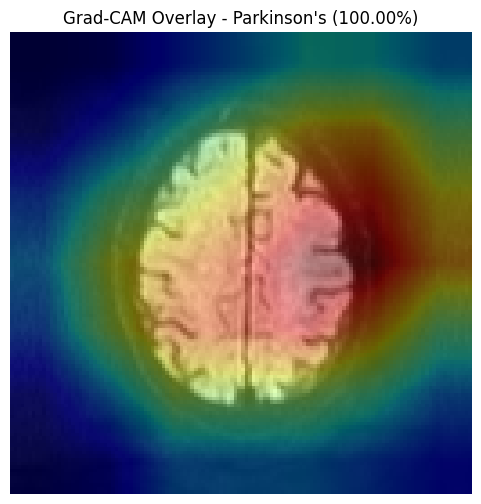

Grad-CAM saved to: gradcam_outputs/sDW_SSh_038_parkinson's.jpg


In [ ]:
import os

# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/parkinson/sDW_SSh_038.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Predict class
prediction = model.predict(img_array)[0][0]
confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)
predicted_label = "Parkinson's" if prediction > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display and save the Grad-CAM overlay
def display_and_save_gradcam(img_path, heatmap, label, confidence, output_dir="gradcam_outputs"):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_rgb, 0.4, 0)

    # label + confidence title
    title = f"{label} ({confidence * 100:.2f}%)"

    # Display
    plt.figure(figsize=(6, 6))
    plt.title(f"Grad-CAM Overlay - {title}")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

    # Save
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.basename(img_path).split('.')[0] + f"_{label.lower().replace(' ', '_')}.jpg"
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
    print(f"Grad-CAM saved to: {save_path}")

# Running the combined display and save function
display_and_save_gradcam(img_path, heatmap, predicted_label, confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


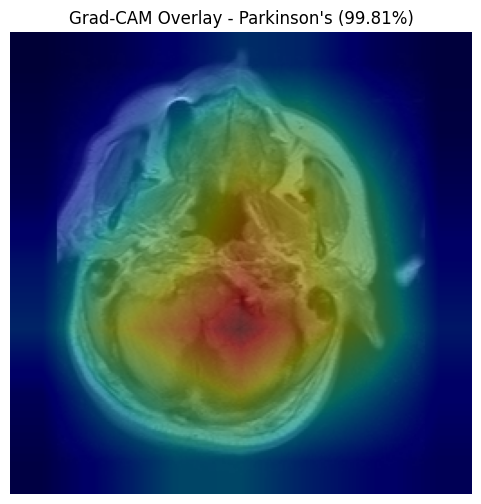

Grad-CAM saved to: gradcam_outputs/DUAL_TSE_001_parkinson's.jpg


In [ ]:
import os

# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/parkinson/DUAL_TSE_001.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Predict class
prediction = model.predict(img_array)[0][0]
confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)
predicted_label = "Parkinson's" if prediction > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display and save the Grad-CAM overlay
def display_and_save_gradcam(img_path, heatmap, label, confidence, output_dir="gradcam_outputs"):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_rgb, 0.4, 0)

    # label + confidence title
    title = f"{label} ({confidence * 100:.2f}%)"

    # Display
    plt.figure(figsize=(6, 6))
    plt.title(f"Grad-CAM Overlay - {title}")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

    # Save
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.basename(img_path).split('.')[0] + f"_{label.lower().replace(' ', '_')}.jpg"
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
    print(f"Grad-CAM saved to: {save_path}")

# Running the combined display and save function
display_and_save_gradcam(img_path, heatmap, predicted_label, confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


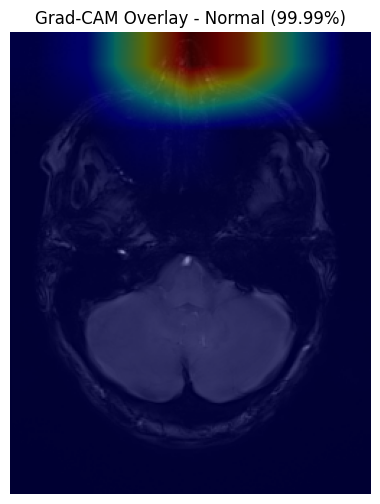

Grad-CAM saved to: gradcam_outputs/Mag_Images_015_normal.jpg


In [ ]:
import os

# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/normal/Mag_Images_015.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Predict class
prediction = model.predict(img_array)[0][0]
confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)
predicted_label = "Parkinson's" if prediction > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display and save the Grad-CAM overlay
def display_and_save_gradcam(img_path, heatmap, label, confidence, output_dir="gradcam_outputs"):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_rgb, 0.4, 0)

    # label + confidence title
    title = f"{label} ({confidence * 100:.2f}%)"

    # Display
    plt.figure(figsize=(6, 6))
    plt.title(f"Grad-CAM Overlay - {title}")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

    # Save
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.basename(img_path).split('.')[0] + f"_{label.lower().replace(' ', '_')}.jpg"
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
    print(f"Grad-CAM saved to: {save_path}")

# Running the combined display and save function
display_and_save_gradcam(img_path, heatmap, predicted_label, confidence)

# **CHECK BELOW**

No signs of Parkinson’s detected. The model predicted 'Normal' with high confidence, and Grad-CAM did not highlight any specific brain regions

If the Grad-CAM heatmap is all zeros (or very close to zero), it means:

The last convolutional layer didn’t produce activations that were important for the prediction.

This is expected behavior for normal (non-Parkinson’s) cases — the model has nothing to "explain" in terms of disease features.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


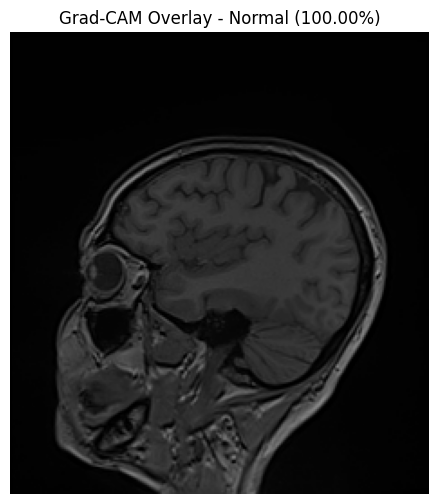

Grad-CAM saved to: gradcam_outputs/t1_fl3d_sag_p4_iso_1_normal.jpg


In [ ]:
import os

# image path
img_path = "/content/parkinsons_mri/parkinsons_dataset/normal/t1_fl3d_sag_p4_iso_1.0_051.png"

# Load and preprocess
img_array = load_and_preprocess_image(img_path)

# Predict class
prediction = model.predict(img_array)[0][0]
confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)
predicted_label = "Parkinson's" if prediction > 0.5 else "Normal"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="block14_sepconv2_act")

# Display and save the Grad-CAM overlay
def display_and_save_gradcam(img_path, heatmap, label, confidence, output_dir="gradcam_outputs"):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_rgb, 0.4, 0)

    # label + confidence title
    title = f"{label} ({confidence * 100:.2f}%)"

    # Display
    plt.figure(figsize=(6, 6))
    plt.title(f"Grad-CAM Overlay - {title}")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

    # Save
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.basename(img_path).split('.')[0] + f"_{label.lower().replace(' ', '_')}.jpg"
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
    print(f"Grad-CAM saved to: {save_path}")

# Running the combined display and save function
display_and_save_gradcam(img_path, heatmap, predicted_label, confidence)